<a href="https://colab.research.google.com/github/manasbegaliev777-dev/flare-emission-monitoring/blob/main/Flare_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **«Система мониторинга экологических показателей факела на основе ИИ»**

### Шаг 1: Установка библиотек и подготовка окружения
Назначение: Установка необходимых зависимостей для работы с компьютерным зрением и API Roboflow.

In [24]:
# Установка библиотеки Roboflow для взаимодействия с моделью
!pip install roboflow -q
# Установка SDK для инференса (опционально, но рекомендуется для стабильности)
!pip install inference-sdk -q

import roboflow
import cv2
import numpy as np
import os
from google.colab import drive
from google.colab.patches import cv2_imshow

print("Библиотеки успешно импортированы.")

Библиотеки успешно импортированы.


## Шаг 2: Авторизация и подключение данных
Назначение: Монтирование Google Диска для доступа к фотографиям завода и инициализация предобученной модели.

In [25]:
# 1. Подключение Google Диска для работы с реальными фото факелов
drive.mount('/content/drive')

# 2. Инициализация API Roboflow
# Используется персональный API-ключ и проект по сегментации огня/дыма
rf = roboflow.Roboflow(api_key="1tJEFAZ6OaygYBSnTHyj")
project = rf.workspace().project("fire-and-smoke-segmentation")
model = project.version(5).model

# 3. Указание пути к анализируемому файлу на Диске
file_path = "/content/drive/MyDrive/Colab Notebooks/факел_с_дымом.jpg"

if os.path.exists(file_path):
    print(f"Система готова к анализу файла: {file_path}")
else:
    print("ВНИМАНИЕ: Файл не найден. Проверьте путь в переменной file_path.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading Roboflow workspace...
loading Roboflow project...
Система готова к анализу файла: /content/drive/MyDrive/Colab Notebooks/факел_с_дымом.jpg


## Шаг 3: Интеллектуальный анализ горения и визуализация
Назначение: Выполнение предсказания, расчет экологических показателей (соотношение огня/дыма) и вывод финального отчета с наложением графики.

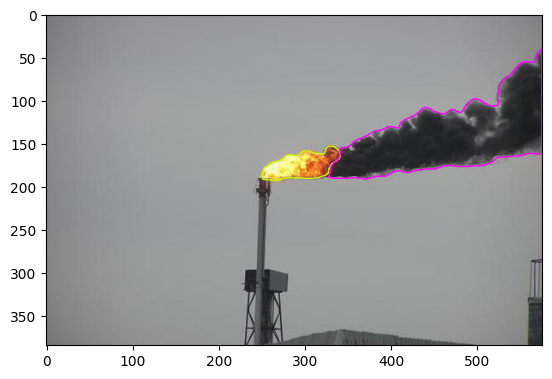

--- ОТЧЕТ ПО ЭКОЛОГИЧЕСКОМУ МОНИТОРИНГУ ПРОМЫШЛЕННОГО ФАКЕЛА ---
Точность распознавания: Огонь - 83.1%, Дым - 78.9%
Экологическая пропорция: Огонь - 8.7%, Дым - 91.3%
----------------------------------------------------------------------
🚨 СТАТУС: ВЫСОКОЕ ЗАДЫМЛЕНИЕ
РЕКОМЕНДАЦИЯ: Требуется регулировка подачи смеси!


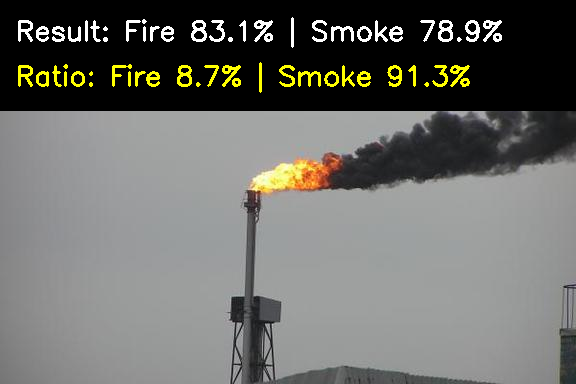

In [26]:
# 1. Загрузка изображения средствами OpenCV
image_raw = cv2.imread(file_path)

if image_raw is None:
    print("Ошибка: Не удалось считать изображение. Проверьте формат файла.")
else:
    # 2. Запуск нейросетевого анализа (Confidence 40% для отсечения шумов)
    prediction_result = model.predict(file_path, confidence=40)
    results_json = prediction_result.json()
    predictions = results_json.get('predictions', [])

    # Отрисовка масок сегментации через встроенный метод Roboflow
    annotated_image = prediction_result.plot()
    if annotated_image is None:
        annotated_image = image_raw.copy()

    if not predictions:
        print("--- АНАЛИЗ ЗАВЕРШЕН ---")
        print("Огонь или дым не обнаружены. Горение отсутствует или камера перекрыта.")
        cv2_imshow(annotated_image)
    else:
        # Инициализация счетчиков для экологического мониторинга
        fire_pixel_area = 0
        smoke_pixel_area = 0
        fire_conf = 0
        smoke_conf = 0

        # 3. Сбор данных по каждому обнаруженному объекту
        for det in predictions:
            label = det['class'].lower()
            conf = det['confidence'] * 100
            # Расчет площади зоны (в относительных единицах/пикселях)
            area = det.get('width', 0) * det.get('height', 0)

            if label == 'fire':
                fire_pixel_area += area
                fire_conf = max(fire_conf, conf)
            elif label == 'smoke':
                smoke_pixel_area += area
                smoke_conf = max(smoke_conf, conf)

        # 4. Расчет критического показателя: соотношение Огонь/Дым
        total_area = fire_pixel_area + smoke_pixel_area
        fire_ratio = (fire_pixel_area / total_area * 100) if total_area > 0 else 0
        smoke_ratio = (smoke_pixel_area / total_area * 100) if total_area > 0 else 0

        # 5. Визуализация бизнес-метрик на кадре
        # Отрисовка панели мониторинга (черный фон для читаемости текста)
        cv2.rectangle(annotated_image, (0, 0), (700, 110), (0, 0, 0), -1)

        font = cv2.FONT_HERSHEY_SIMPLEX
        line1 = f"Result: Fire {fire_conf:.1f}% | Smoke {smoke_conf:.1f}%"
        line2 = f"Ratio: Fire {fire_ratio:.1f}% | Smoke {smoke_ratio:.1f}%"

        cv2.putText(annotated_image, line1, (15, 40), font, 0.9, (255, 255, 255), 2)
        cv2.putText(annotated_image, line2, (15, 85), font, 0.9, (0, 255, 255), 2)

        # 6. Финальный вывод для принятия инженерных решений
        print("=" * 70)
        print("--- ОТЧЕТ ПО ЭКОЛОГИЧЕСКОМУ МОНИТОРИНГУ ПРОМЫШЛЕННОГО ФАКЕЛА ---")
        print("=" * 70)
        print(f"Точность распознавания: Огонь - {fire_conf:.1f}%, Дым - {smoke_conf:.1f}%")
        print(f"Экологическая пропорция: Огонь - {fire_ratio:.1f}%, Дым - {smoke_ratio:.1f}%")
        print("-" * 70)

        if smoke_ratio > 50:
            print("🚨 СТАТУС: ВЫСОКОЕ ЗАДЫМЛЕНИЕ")
            print("РЕКОМЕНДАЦИЯ: Требуется регулировка подачи смеси!")
        else:
            print("✅ СТАТУС: ГОРЕНИЕ В НОРМЕ")
            print("РЕКОМЕНДАЦИЯ: Поддерживать текущий режим работы")
            print("=" * 70)

        # Вывод обработанного изображения
        cv2_imshow(annotated_image)